# Atividade 04 - Tópicos: Mineração de Repositório de Software

**Grupo 4: Lays de Freitas e Saulo Soares**

Importanto bibliotecas necessárias:

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

#Classificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

Definindo a função de Tokenizaçao:

In [2]:
# Tokenização
def tokenize(text):
    # Tokenização
    tokens = nltk.word_tokenize(text)
    
    # Stemização
    stems  = []
    for item in tokens:
        stems.append(SnowballStemmer("english").stem(item))
    return stems

Conectando com o drive para realizar a leitura do dataset "Eclipse.csv".

**Nota: Alteramos o dataset para incluir o nome das colunas.**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Carregando os dados
df = pd.read_csv('/content/drive/My Drive/Mineração/Atividade04/Eclipse_total.csv') # Salvamos com esse nome antes

# Imprimindo começo do dataset
df.head()

,ID,ProductName,ProcessedSummary,ProcessedDescription,ComponentName,SeverityLevel,Priority,Developers,Topic,Status
0,221036,Community,unabl enter request parti code cq,report enter request parti librari submit java...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,d_a_carver bjorn.freeman-benson karl.matthias,FIXED
1,221203,Community,submit request cq cq submit,submit request cq cq submit creat screen retur...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,d_a_carver d_a_carver bjorn.freeman-benson kar...,FIXED
2,243952,Community,ca submit cq rd parti contribut develop apach,valid apach url enter url project page apach p...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,ekuleshov ekuleshov bjorn.freeman-benson ekule...,FIXED
3,230229,Community,tool link fail ie,webmast email tool link respond js error error...,Project Management & Portal,blocker,P1,gabe.obrien,webmaster webmaster bjorn.freeman-benson karl....,FIXED
4,229095,Community,cron total broken,portal cron job broken friday gabe debug fix c...,Project Management & Portal,blocker,P1,portal-inbox,karl.matthias karl.matthias karl.matthias karl...,FIXED


Vamos olhar os tipos de valores diferentes da coluna 'Status:




In [6]:
# Valores de "Status"
class_names = df['Status'].unique()
class_names

array(['FIXED'], dtype=object)

Como só tem o "FIXED" não precisamos remover nenhum entrada do dataset. Dessa forma, vamos olhar os valores agora da coluna "SeverityLevel":

In [7]:
# Valores de "SeverityLevel"
class_names = df['SeverityLevel'].unique()
class_names

array(['blocker', 'critical', 'major', 'normal', 'enhancement', 'minor',
       'trivial'], dtype=object)

Temos valores que não queremos, logo, devemos remover entradas diferentes de "blocker", "critical", "major","minor" e "trivial":

In [8]:
# Removendo valores
processedDataset = df[(df.SeverityLevel == "blocker") | (df.SeverityLevel == "critical") | (df.SeverityLevel == "major") | (df.SeverityLevel == "minor") | (df.SeverityLevel == "trivial")]

# Apresentando dataset
processedDataset.head()

,ID,ProductName,ProcessedSummary,ProcessedDescription,ComponentName,SeverityLevel,Priority,Developers,Topic,Status
0,221036,Community,unabl enter request parti code cq,report enter request parti librari submit java...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,d_a_carver bjorn.freeman-benson karl.matthias,FIXED
1,221203,Community,submit request cq cq submit,submit request cq cq submit creat screen retur...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,d_a_carver d_a_carver bjorn.freeman-benson kar...,FIXED
2,243952,Community,ca submit cq rd parti contribut develop apach,valid apach url enter url project page apach p...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,ekuleshov ekuleshov bjorn.freeman-benson ekule...,FIXED
3,230229,Community,tool link fail ie,webmast email tool link respond js error error...,Project Management & Portal,blocker,P1,gabe.obrien,webmaster webmaster bjorn.freeman-benson karl....,FIXED
4,229095,Community,cron total broken,portal cron job broken friday gabe debug fix c...,Project Management & Portal,blocker,P1,portal-inbox,karl.matthias karl.matthias karl.matthias karl...,FIXED


Verificando que tudo ocorreu bem:

In [ ]:
class_names = processedDataset['SeverityLevel'].unique()
class_names

array(['blocker', 'critical', 'major', 'minor', 'trivial'], dtype=object)

Temos apenas os valores que queremos. Tudo certo!

Agora vamos concatenar as colunas de "ProcessedSummary" e "ProcessedDescription" em uma única coluna chamada "combinedSumAndDec":

In [9]:
# Concatenando colunas
processedDataset["combinedSumAndDesc"] = processedDataset["ProcessedSummary"] + processedDataset["ProcessedDescription"]
processedDataset.head()

,ID,ProductName,ProcessedSummary,ProcessedDescription,ComponentName,SeverityLevel,Priority,Developers,Topic,Status,combinedSumAndDesc
0,221036,Community,unabl enter request parti code cq,report enter request parti librari submit java...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,d_a_carver bjorn.freeman-benson karl.matthias,FIXED,unabl enter request parti code cq report enter...
1,221203,Community,submit request cq cq submit,submit request cq cq submit creat screen retur...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,d_a_carver d_a_carver bjorn.freeman-benson kar...,FIXED,submit request cq cq submit submit request cq ...
2,243952,Community,ca submit cq rd parti contribut develop apach,valid apach url enter url project page apach p...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,ekuleshov ekuleshov bjorn.freeman-benson ekule...,FIXED,ca submit cq rd parti contribut develop apach ...
3,230229,Community,tool link fail ie,webmast email tool link respond js error error...,Project Management & Portal,blocker,P1,gabe.obrien,webmaster webmaster bjorn.freeman-benson karl....,FIXED,tool link fail ie webmast email tool link resp...
4,229095,Community,cron total broken,portal cron job broken friday gabe debug fix c...,Project Management & Portal,blocker,P1,portal-inbox,karl.matthias karl.matthias karl.matthias karl...,FIXED,cron total broken portal cron job broken frida...


Agora, vamos excluior as colunas desnecessárias. Vamos retirar "ProcessedSummary", "ProcessedDescription" e "ComponentName":

In [10]:
# Removendo colunas desnecessárias
processedDataset.drop('ProcessedSummary', inplace=True, axis=1)
processedDataset.drop('ProcessedDescription', inplace=True, axis=1)
processedDataset.drop('ComponentName', inplace=True, axis=1)
processedDataset.head()

,ID,ProductName,SeverityLevel,Priority,Developers,Topic,Status,combinedSumAndDesc
0,221036,Community,blocker,P1,bjorn.freeman-benson,d_a_carver bjorn.freeman-benson karl.matthias,FIXED,unabl enter request parti code cq report enter...
1,221203,Community,blocker,P1,bjorn.freeman-benson,d_a_carver d_a_carver bjorn.freeman-benson kar...,FIXED,submit request cq cq submit submit request cq ...
2,243952,Community,blocker,P1,bjorn.freeman-benson,ekuleshov ekuleshov bjorn.freeman-benson ekule...,FIXED,ca submit cq rd parti contribut develop apach ...
3,230229,Community,blocker,P1,gabe.obrien,webmaster webmaster bjorn.freeman-benson karl....,FIXED,tool link fail ie webmast email tool link resp...
4,229095,Community,blocker,P1,portal-inbox,karl.matthias karl.matthias karl.matthias karl...,FIXED,cron total broken portal cron job broken frida...


Vamos verificar por valores NaN, já que o classificador não consegue lidar com isso:

In [11]:
# Verificando entradas vazias na coluna "combinedSumAndDesc"
processedDataset['combinedSumAndDesc'].isnull().sum()

62

Podemos ver que a coluna de "combinedSumAndDesc" possui 62 entradas vazias. Logo, vamos retirá-las:

In [12]:
# Retirando entradas vazias
processedDataset = processedDataset.dropna()
processedDataset['combinedSumAndDesc'].isnull().sum()

0

Tudo certo agora, vamos dividir o dataset no conjunto de teste e de treinamento:

In [14]:
# Split Dataset nas colunas "combinedSumAndDesc" e "SeverityLevel"
X_train, X_test, y_train, y_test = train_test_split(processedDataset[['combinedSumAndDesc']], processedDataset.SeverityLevel, random_state=42)
X_train.shape

(5535, 1)

**Classificador KNeighborsClassifier:**

In [15]:
# Stop Words
nltk.download('stopwords')

nltk.download('punkt')

stop_words = nltk.corpus.stopwords.words('english')

# NLP Pipeline
text_clf   = Pipeline([
                # Vectorize
                ('vect',  TfidfVectorizer(tokenizer=tokenize, 
                                          stop_words=stop_words, 
                                          ngram_range=(1,2))),
                # Classificador
                ('clf',   KNeighborsClassifier(n_jobs=-1)),
            ])

# Train
text_clf = text_clf.fit(X_train.combinedSumAndDesc, y_train)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
text_clf.score(X_test.combinedSumAndDesc, y_test)

0.421680216802168

**Métrica F1_Score do classificador KNeighborsClassifier:**

In [17]:
predictions = text_clf.predict(X_test.combinedSumAndDesc)
f1_score(y_test, predictions, average='weighted')

0.4100016349408238

**Métrica matriz de confusão do classificador KNeighborsClassifier:**

In [18]:
conf_matrix = confusion_matrix(y_test,predictions)

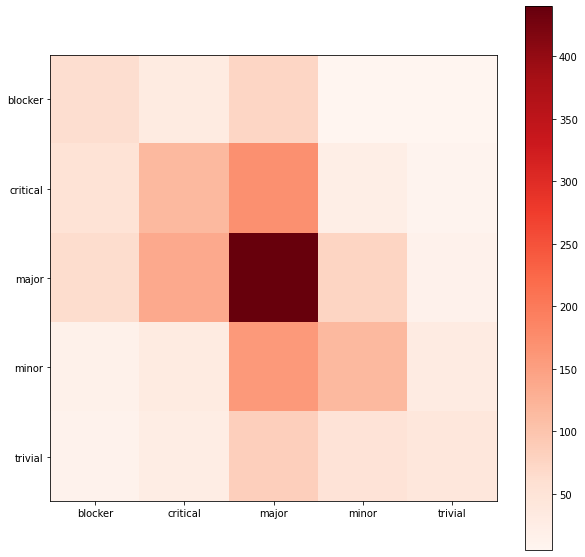

In [19]:
plt.figure(figsize=(10,10))
plt.xticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.yticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.imshow(conf_matrix,cmap=plt.cm.Reds)
plt.colorbar()

**Classificador MultinomialNB:**

In [20]:
# Stop Words
nltk.download('stopwords')

nltk.download('punkt')

stop_words = nltk.corpus.stopwords.words('english')

# NLP Pipeline
text_clf   = Pipeline([
                # Vectorize
                ('vect',  TfidfVectorizer(tokenizer=tokenize, 
                                          stop_words=stop_words, 
                                          ngram_range=(1,2))),
                # Classificador
                ('clf',   MultinomialNB ()),
            ])

# Train
text_clf = text_clf.fit(X_train.combinedSumAndDesc, y_train)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
text_clf.score(X_test.combinedSumAndDesc, y_test)

0.4

**Métrica F1_Score do classificador MultinomialNB:**

In [22]:
predictions = text_clf.predict(X_test.combinedSumAndDesc)
f1_score(y_test, predictions, average='weighted')

0.2342207946676482

**Métrica matriz de confusão do classificador MultinomialNB:**

In [23]:
conf_matrix = confusion_matrix(y_test,predictions)

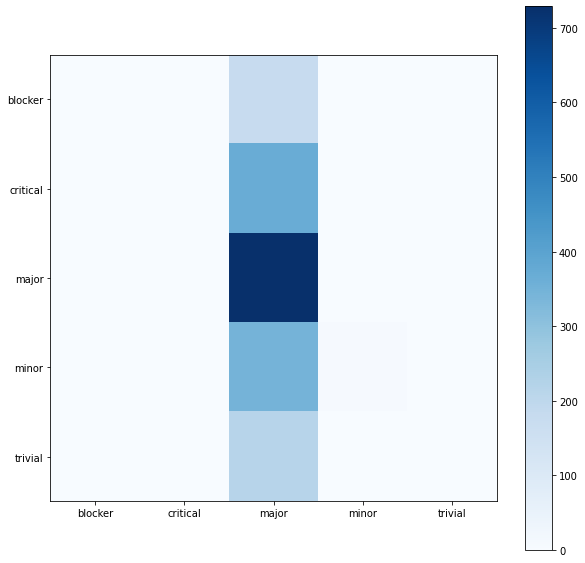

In [24]:
plt.figure(figsize=(10,10))
plt.xticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.yticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.imshow(conf_matrix,cmap=plt.cm.Blues)
plt.colorbar()

**Classificador SVC:**

In [25]:
# Stop Words
nltk.download('stopwords')

nltk.download('punkt')

stop_words = nltk.corpus.stopwords.words('english')

# NLP Pipeline
text_clf   = Pipeline([
                # Vectorize
                ('vect',  TfidfVectorizer(tokenizer=tokenize, 
                                          stop_words=stop_words, 
                                          ngram_range=(1,2))),
                # Classificador
                ('clf',   SVC(kernel='linear', C=1E10)),
            ])

# Train
text_clf = text_clf.fit(X_train.combinedSumAndDesc, y_train)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
text_clf.score(X_test.combinedSumAndDesc, y_test)

0.5051490514905149

**Métrica F1_Score do classificador SVC:**

In [27]:
predictions = text_clf.predict(X_test.combinedSumAndDesc)
f1_score(y_test, predictions, average='weighted')

0.49505289717794815

**Métrica matriz de confusão do classificador SVC:**

In [28]:
conf_matrix = confusion_matrix(y_test,predictions)

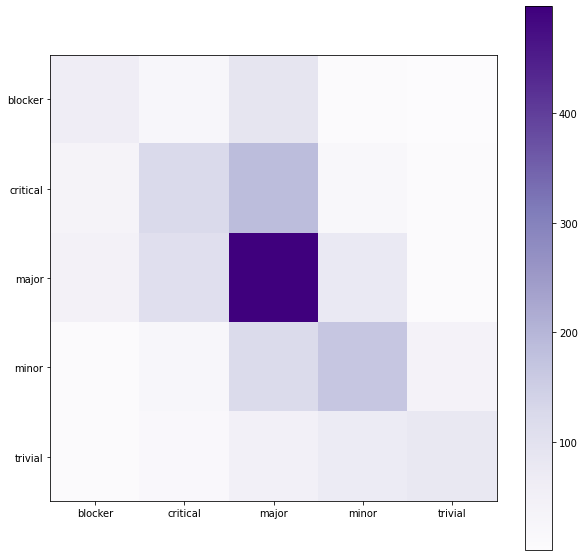

In [29]:
plt.figure(figsize=(10,10))
plt.xticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.yticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.imshow(conf_matrix,cmap=plt.cm.Purples)
plt.colorbar()